In [80]:
#Importing all the required libraries,Done on google colab.
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.color import rgb2gray
# cv2 import dnn_superres
from google.colab import files
import math
import pywt
import pywt.data
import scipy.stats as stats


In [5]:
uploaded = files.upload() #To upload files on to google colab drive.

Saving satellite image.jpg to satellite image.jpg


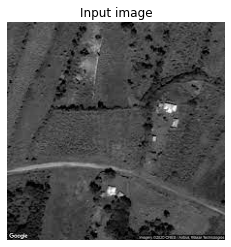

In [82]:
img = cv.imread("satellite image.jpg", cv.IMREAD_COLOR)#reading the input image.
plt.axis('off')
plt.title('Input image')
plt.imshow(img)
plt.show()

In [83]:
# fetching the dimensions
wid = img.shape[1]
hgt = img.shape[0]
  
# displaying the dimensions
print(str(wid) + "x" + str(hgt))


225x225


# New Section

In [84]:
## !pip install opencv-contrib-python==4.3.0.36 #installing required version of opencv for DNN superres modules.

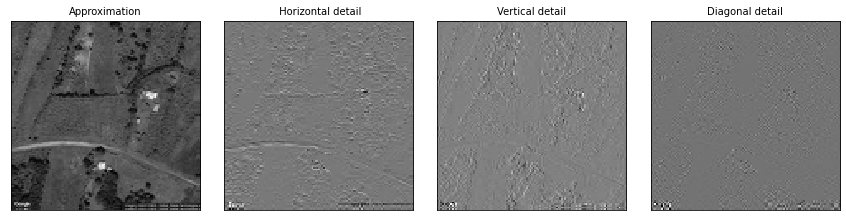

In [85]:
im = rgb2gray(img) #rgb to gray conversion for dwt


# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs1 = pywt.dwt2(im, 'bior1.3') #function for 2d-dwt,with biorthogonal as mother wavelet.
LL1, (LH1, HL1, HH1) = coeffs1
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL1, LH1, HL1, HH1]): #plotting the four sub bands.
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


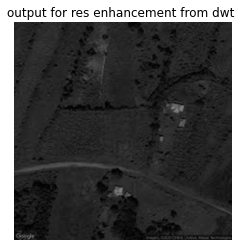

In [86]:
#interpolation for increasing dimension..
dim=(900,900)
A = cv.resize(im, dim, interpolation = cv.INTER_CUBIC) #using intercubic interpolation
B = cv.resize(LH1, dim, interpolation = cv.INTER_CUBIC)
C = cv.resize(HL1, dim, interpolation = cv.INTER_CUBIC)
D = cv.resize(HH1, dim, interpolation = cv.INTER_CUBIC)

coeffs=A,(B, C, D)
final_image=pywt.idwt2(coeffs,'bior1.3') #inverse 2d dwt

gray_three = cv.merge([final_image,final_image,final_image])
plt.axis('off')
plt.title('output for res enhancement from dwt ')
plt.imshow(gray_three)
plt.show()


In [87]:
#Function for calculating Peak signal to noise ratio.
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


dim=(225,225)
result1 = cv.resize(gray_three, dim, interpolation = cv.INTER_CUBIC)
d1 = psnr(img, result1)
print("PSNR:",d1)

PSNR: 10.596179118406077


In [88]:
Y = np.square(np.subtract(img,result1)).mean()
print("MSE:", Y)

MSE: 5668.425577536371


In [89]:
from cv2 import dnn_superres #importing module for super resolution network models.


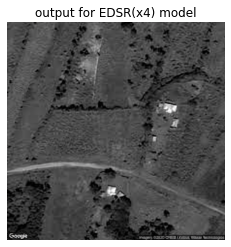

In [90]:
# Create an SR object
sr = dnn_superres.DnnSuperResImpl_create()

# Read image
#image = cv2.imread('./input.png')

# Read the desired model
path = "/content/drive/MyDrive/EDSR_x4.pb"
sr.readModel(path)

# Set the desired model and scale to get correct pre- and post-processing
sr.setModel("edsr", 4)

# Upscale the image
result = sr.upsample(img)

plt.title('output for EDSR(x4) model')
plt.axis('off')
plt.imshow(result)
plt.show()

In [21]:
# fetching the dimensions
wid = result.shape[1]
hgt = result.shape[0]
  
# displaying the dimensions
print(str(wid) + "x" + str(hgt))


900x900


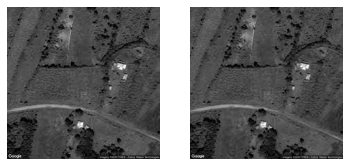

In [22]:
#showing both input and res enhaced images .
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(result)
plt.axis('off')

plt.show()

In [23]:
#reducing the dimension to check psnr and mse.
dim=(225,225)
result2 = cv.resize(result, dim, interpolation = cv.INTER_CUBIC)

In [24]:
# fetching the dimensions
wid = result2.shape[1]
hgt = result2.shape[0]
  
# displaying the dimensions
print(str(wid) + "x" + str(hgt))


225x225


In [91]:
d2 = psnr(img, result2)
print("PSNR:",d2)
#more PSNR obtained for EDSR model.0

PSNR: 61.20723118586862


In [92]:
Y2 = np.square(np.subtract(img,result2)).mean()
print("MSE:", Y2)

MSE: 0.049244444444444445


In [93]:
#taking the result of EDSR as input for contrast enhancement,conveting into gray image.
im = rgb2gray(result)


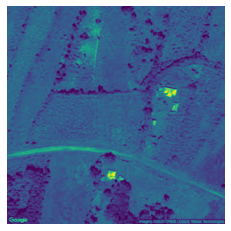

In [94]:
im.shape
plt.imshow(im)
plt.axis('off')
plt.show()

In [95]:
flat1=im.flatten()

In [96]:
#mean and standard deviation of the res enhanced image.
m1=np.mean(flat1)
sd1=np.std(flat1)


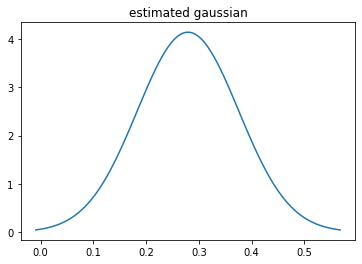

In [97]:
#estimated gaussian distribution
x = np.linspace(m1 - 3*sd1, m1 + 3*sd1, 100)
plt.plot(x, stats.norm.pdf(x, m1, sd1))
plt.title('estimated gaussian')
plt.show()

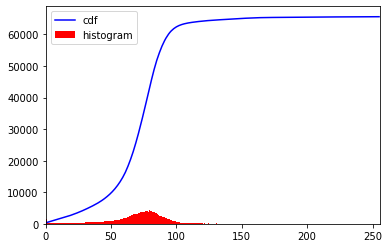

In [98]:
#Histogram of res enhanced image,can be seen that histogram is concentrated at only one place on the distribution.
hist,bins = np.histogram(result.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [99]:
#To equalize the histogram
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

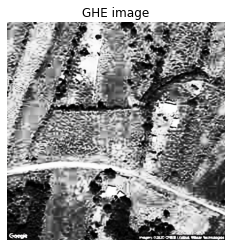

In [100]:
img2 = cdf[result] #GHE image
plt.axis('off')
plt.title('GHE image')
plt.imshow(img2)
plt.show()

In [101]:
im2 = rgb2gray(img2)


In [102]:
img2.shape

(900, 900, 3)

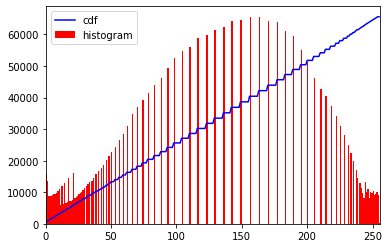

In [103]:
#Histogram of the GHE image.
hist,bins = np.histogram(img2.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

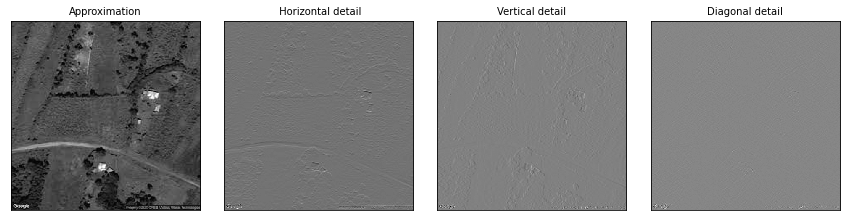

In [104]:

#2D-DWT on res enhanced image
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs1 = pywt.dwt2(im, 'bior1.3')
LL1, (LH1, HL1, HH1) = coeffs1
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL1, LH1, HL1, HH1]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

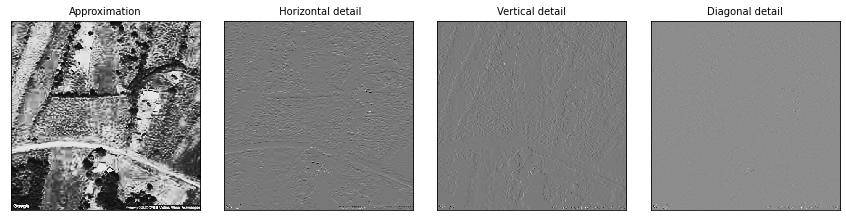

In [105]:
#2D-DWT on GHE image

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(im2, 'bior1.3')
LL2, (LH2, HL2, HH2) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL2, LH2, HL2, HH2]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [106]:
LL1.shape

(452, 452)

In [107]:
U1, S1, V1 = np.linalg.svd(LL1)#input image LL band's SVD


In [108]:
s1=np.max(S1)
s1

254.23214874331484

In [109]:
U2, S2, V2 = np.linalg.svd(LL2) #ghe image"s SVD
S2.shape

(452,)

In [110]:
s2=np.max(S2)
s2

462.9935532146742

In [111]:
eta=s2/s1 #Equalizing factor eta.
eta

1.8211447903157796

In [112]:
SS1=eta*np.diag(S1) 

SS1.shape

(452, 452)

In [113]:
x=np.dot(SS1,V1)
final_LL1=np.dot(U1,x)#equalised LL band
final_LL1.shape

(452, 452)

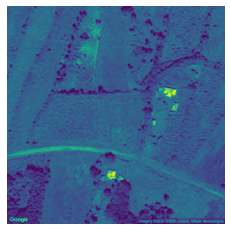

In [114]:
plt.axis('off')
plt.imshow(final_LL1)
plt.show()

In [115]:
coeffs=final_LL1,(LH1, HL1, HH1)
final_image=pywt.idwt2(coeffs,'bior1.3')

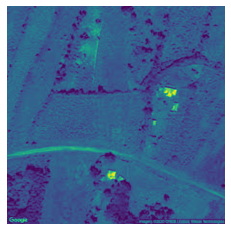

In [116]:
plt.axis('off')
plt.imshow(final_image)
plt.show()

In [117]:
final_image.shape

(900, 900)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


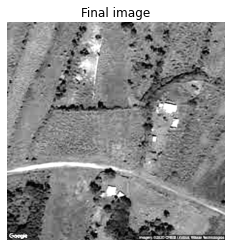

In [118]:
gray_three = cv.merge([final_image,final_image,final_image])
plt.axis('off')
plt.imshow((gray_three))
plt.title('Final image')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


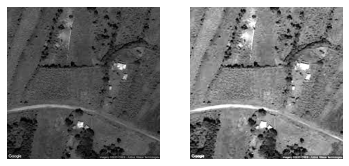

In [120]:
#showing both input and final images .
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(gray_three)
plt.axis('off')

plt.show()

In [121]:
flat2=final_image.flatten()

In [130]:
#mean and standard dev of final image
m2=np.mean(flat2)
sd2=np.std(flat2)

0.09624180421798395

In [129]:
#estimated gaussian distribution
x = np.linspace(m2 - 3*sd2, m2 + 3*sd2, 100)
plt.plot(x, stats.norm.pdf(x, m2, sd2))
plt.title('estimated gaussian of final image')
plt.show()
#can be seen that inc in sd after contrast enhancement.

In [124]:
#to mount the google drive for EDSR(x4) model.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
